In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [4]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [5]:
main_dir = '/home/yulia/W266-Final-Project/'

In [6]:
data_path = main_dir+'data/raw/hein-daily'

In [7]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [8]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

### Create 30% sample because party model has more data where target = 1

In [9]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt', p=0.3)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 11.7 seconds to create the dictionary


In [10]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [11]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

In [12]:
np.unique(np.array(party), return_counts=True)

(array(['A', 'D', 'I', 'N', 'NA', 'P', 'R'], dtype='<U2'),
 array([      4,  448302,    2265,      89, 3007562,      20,  407959]))

In [13]:
party_dummy = []
for p in range(len(party)):
    if party[p] == 'D':
        party_dummy.append(1)
    elif party[p] == 'R':
        party_dummy.append(0)
    else:
        party_dummy.append(-1)
len(party_dummy)

3866201

### Data QA

In [14]:
explore_data.get_counts(party_dummy)

,Category,Count
0,-1,3009940
1,0,407959
2,1,448302


In [15]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, party_dummy, descr)

Speaker information
date 19920810
char_count 2277
word_count 366
speakerid 102115370.0
Party D
Congress 102
Chamber H
State VA
Ethnicity W
Age 46.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. BOUCHER
Full Name BOUCHER, FREDERICK
match exact
check 1

Mr. Speaker. H.R. days after enactment. 3360 Is designed to protect the Amer- The amendment in the nature of a ican public. Despite the availability substitute under consideration repand affordability of automatic sprin- resents an agreement between the kler systems and smoke detectors. the Science Committee and the CommitUnited States continues to have an un- tees on Public Works and Transporacceptably high fire death rate. Fire Is tation and Banking. Finance. and the third leading cause of accidental Urban Affairs. to which the bill was death. accounting for more than 5.500 jointly referred. deaths each year. This Is a rate that is I would like to thank Mr. ROE. chair50 percent higher than most of the in- man of the Committee on Pu

# Age Model

## Split into train, validate, test

In [17]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, party_dummy, descr)

Training split: 161472 ones and 141987 zeroes
Training speech list size: 303459
Training target list size: 303459
Validation split: 53824 ones and 47329 zeroes
Validation speech list size: 101153
Validation target list size: 101153
Test split: 53825 ones and 47329 zeroes
Test speech list size: 101154
Test target list size: 101154


In [18]:
sum(train_target), sum(val_target), sum(test_target)

(161472, 53824, 53825)

In [19]:
# number of speeches under 30 words
sum(np.array(party_dummy)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

179181

In [20]:
# random speech from a train set where target=1
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19960522
char_count 196
word_count 40
speakerid 104109021.0
Party D
Congress 104
Chamber S
State NE
Ethnicity W
Age 75.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. EXON
Full Name EXON, J.
match exact
check 1

I am not sure the Senator from Iowa heard. I think the Chair was asking him to proceed. The next amendment up is No. 23 on my list. which is No. 4011 by Senator HARKIN. The Senator has 30 seconds.


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [21]:
explore_data.get_num_words_per_sample(train)

227.0

In [22]:
explore_data.get_num_words_per_sample(val)

227.0

In [23]:
explore_data.get_num_words_per_sample(test)

228.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  44.0  70.0  116.0  170.0  227.0  302.0  397.0  545.0  841.0  17835.0


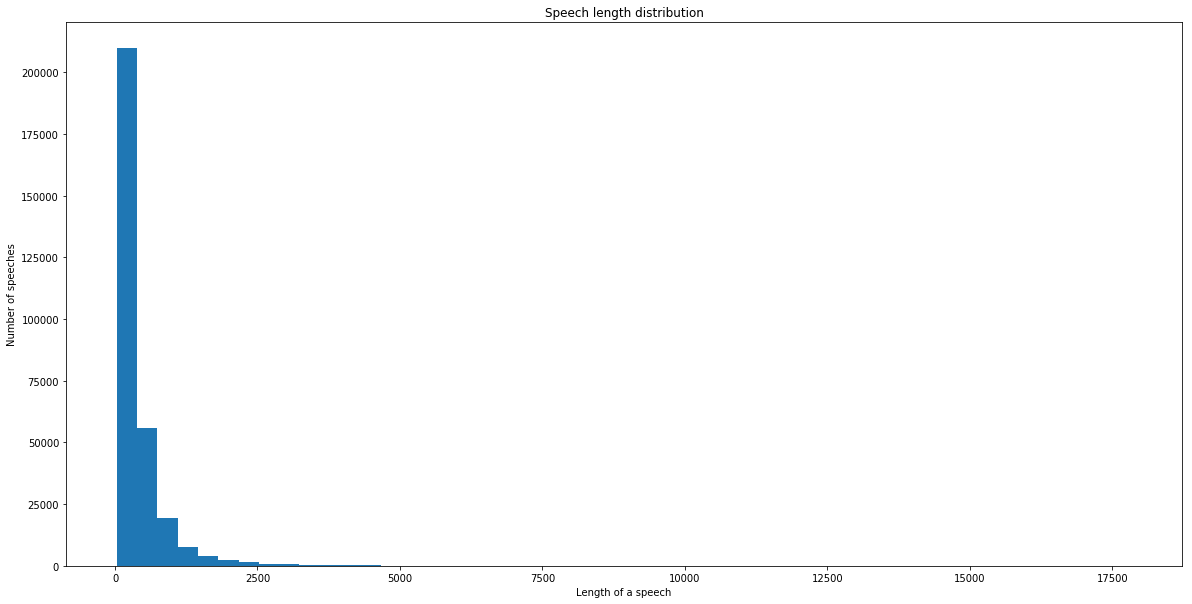

In [24]:
explore_data.plot_sample_length_distribution(train)

In [25]:
train_party = [descr[train_ids[i]]['Party'] for i in range(len(train_ids))]

In [26]:
explore_data.get_counts_by_category(train_target, train_party)

D: 	 161472
R: 	 0


### Most popular ngrams (training only) - exluding stop words

In [27]:
# take a sample to avoid running out of memory
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

60691

['we', 'it', 'have', 'are', 'not', 'be', 'as', 'with', 'our', 'will', 'from', 'by', 'has', 'they', 'was', 'would', 'an', 'my', 'at', 'their', 'bill', 'but', 'or', 'who', 'he', 'do', 'all', 'president', 'which', 'his', 'there', 'what', 'been', 'if', 'about', 'people', 'you', 'these', 'so', 'more', 'time', 'one', 'can', 'speaker', 'amendment', 'years', 'those', 'no', 'other', 'when']


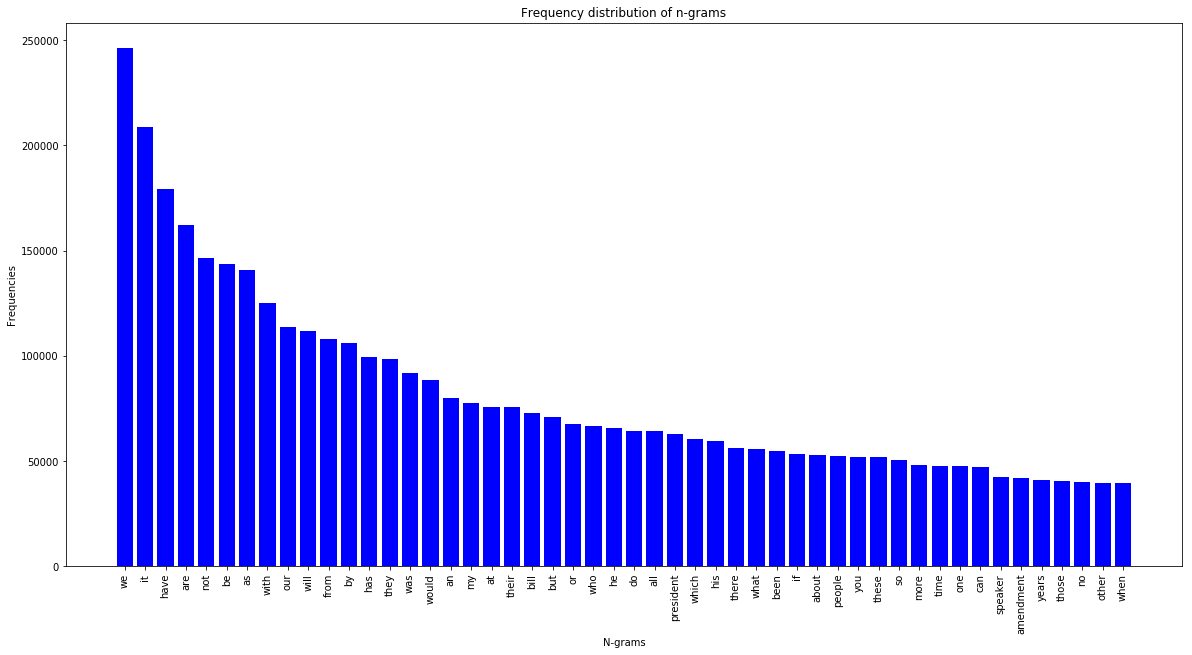

In [28]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

['in the', 'to the', 'it is', 'on the', 'and the', 'for the', 'that the', 'to be', 'we have', 'we are', 'that is', 'mr speaker', 'by the', 'that we', 'with the', 'mr president', 'of this', 'going to', 'in this', 'united states', 'the united', 'is the', 'the senate', 'at the', 'will be', 'this bill', 'from the', 'has been', 'is not', 'this is', 'have been', 'want to', 'of our', 'do not', 'the gentleman', 'there is', 'the bill', 'my colleagues', 'they are', 'to do', 'the house', 'would be', 'one of', 'as the', 'the president', 'the american', 'have to', 'to make', 'we can', 'the federal']


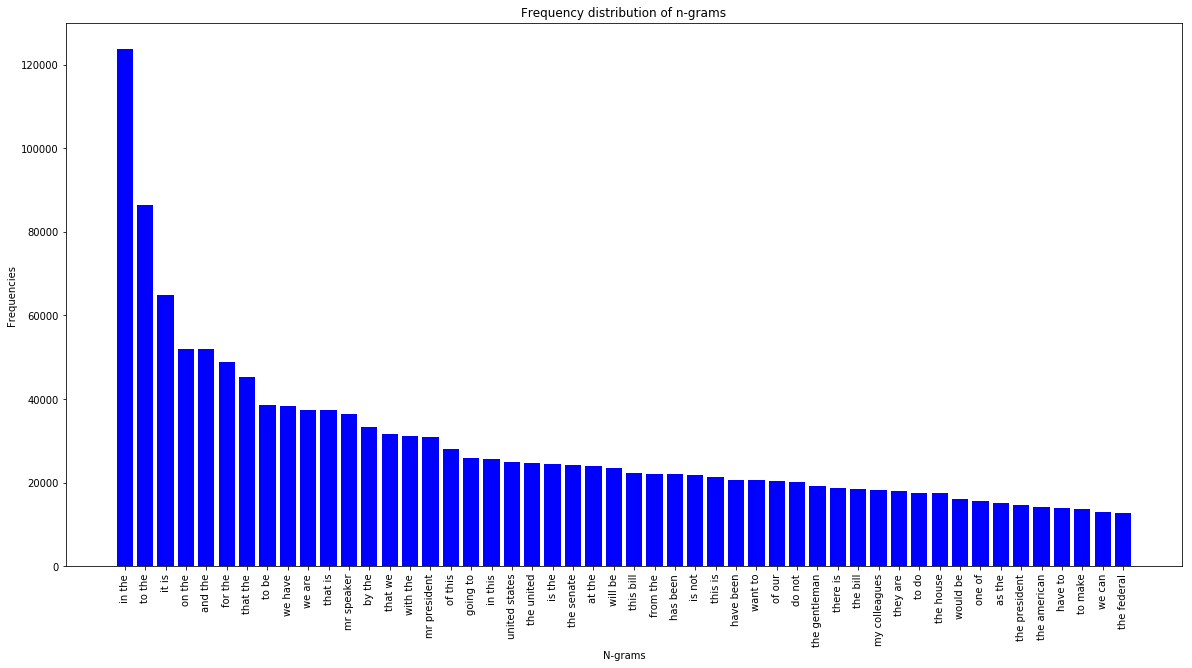

In [29]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

['the united states', 'the gentleman from', 'are going to', 'one of the', 'would like to', 'the senator from', 'the american people', 'my colleagues to', 'of the united', 'the department of', 'we are going', 'is going to', 'it is not', 'ask unanimous consent', 'we need to', 'as well as', 'the federal government', 'be able to', 'chairman of the', 'that we have', 'going to be', 'of the senate', 'member of the', 'the committee on', 'in order to', 'in this country', 'unanimous consent that', 'there is no', 'urge my colleagues', 'in the united', 'mr speaker rise', 'that we are', 'some of the', 'we do not', 'that is the', 'part of the', 'percent of the', 'members of the', 'the fact that', 'rise today to', 'in the senate', 'in support of', 'the people of', 'of the house', 'and that is', 'we have to', 'thank the gentleman', 'on the floor', 'of the aisle', 'the state of']


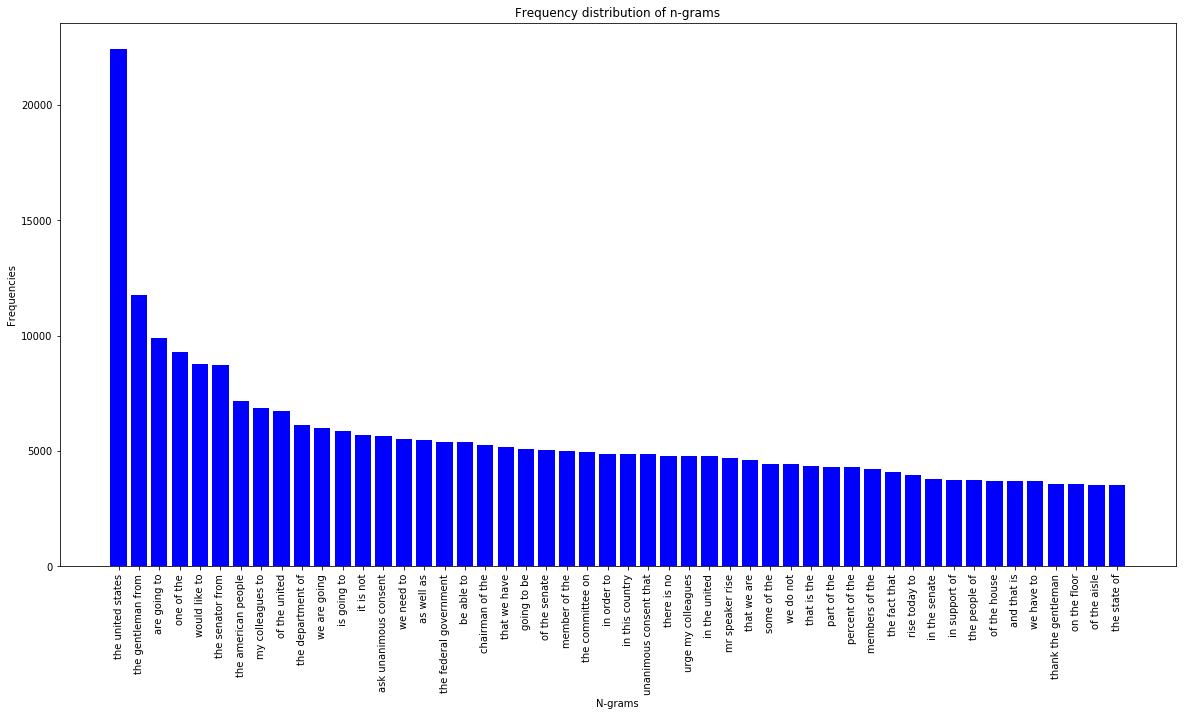

In [30]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [31]:
congress = set([str(i) for i in range(97,115)])

In [32]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 109 top 5 (3, 3) ngrams are:
the united states
one of the
are going to
the gentleman from
the american people
--------------------

For Congress 100 top 5 (3, 3) ngrams are:
the united states
the senator from
the gentleman from
would like to
one of the
--------------------

For Congress 111 top 5 (3, 3) ngrams are:
the united states
the american people
are going to
one of the
is going to
--------------------

For Congress 101 top 5 (3, 3) ngrams are:
the united states
the gentleman from
the senator from
would like to
one of the
--------------------

For Congress 110 top 5 (3, 3) ngrams are:
the united states
are going to
one of the
the american people
we need to
--------------------

For Congress 113 top 5 (3, 3) ngrams are:
the united states
the american people
one of the
mr speaker rise
are going to
--------------------

For Congress 99 top 5 (3, 3) ngrams are:
the united states
the gentleman from
the senator from
would like to
one of the
--------------------

For Congr

In [33]:
explore_data.ngrams_by_category(train, train_ids, descr, {'D','R'}, 'Party', p=0.3, top_n=10)


For Party D top 10 (3, 3) ngrams are:
the united states
the gentleman from
one of the
are going to
the senator from
would like to
my colleagues to
the american people
of the united
the department of
--------------------

For Party R top 10 (3, 3) ngrams are:
the united states
the gentleman from
are going to
the senator from
would like to
one of the
the american people
of the united
is going to
we are going
--------------------


In [34]:
del all_speeches, all_speech_ids, descr

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [35]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 10000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [36]:
reload(preprocess_data)
start_time = time.time()
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Total vocabulary size: 1355920
Number of stop words 9402237

Top 5 ngrams by differentiating score:
republican 	 1139.5
spending 	 925.2
the republican 	 905.4
taxes 	 792.4
the republicans 	 788.3

Bottom 5 ngrams by differentiating score:
coburn of 	 0.0
individual plant 	 0.0
discussed within 	 0.0
employeremployee relationship 	 0.0
criminal to 	 0.0

It took 1140.9 seconds to create the dictionary


In [37]:
len(train), len(val), len(test)

(303459, 101153, 101154)

In [38]:
train_vec.shape, val_vec.shape, test_vec.shape

((303459, 10000), (101153, 10000), (101154, 10000))

### Saving processed files

In [39]:
vecdata_path = main_dir+'Classification/data/vectorized/party'

In [40]:
scipy.sparse.save_npz(os.path.join(vecdata_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'test_vec.npz'), test_vec)

In [48]:
train_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'test_vec.npz'))

In [41]:
train_vec.shape, val_vec.shape, test_vec.shape

((303459, 10000), (101153, 10000), (101154, 10000))

In [42]:
outdata_path = main_dir+'Classification/data/splits/party'

In [43]:
with open(os.path.join(outdata_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(outdata_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(outdata_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(outdata_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(outdata_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(outdata_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(outdata_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(outdata_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(outdata_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [44]:
sum(train_target), sum(val_target), sum(test_target)

(161472, 53824, 53825)

In [53]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [54]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [45]:
sum(val_target), len(val_target)

(53824, 101153)

In [56]:
with open(os.path.join(outdata_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [46]:
sum(train_target), sum(val_target), sum(test_target)

(161472, 53824, 53825)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [47]:
logs_base_dir = main_dir + 'Classification/logs/Party'

In [48]:
ngram_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [49]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **ngram_model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 303459 samples, validate on 101153 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 52s - loss: 0.6003 - acc: 0.6564 - val_loss: 0.5777 - val_acc: 0.6725
Epoch 2/1000
 - 50s - loss: 0.5639 - acc: 0.6842 - val_loss: 0.5708 - val_acc: 0.6762
Epoch 3/1000
 - 51s - loss: 0.5522 - acc: 0.6942 - val_loss: 0.5677 - val_acc: 0.6818
Epoch 4/1000
 - 50s - loss: 0.5428 - acc: 0.7027 - val_loss: 0.5658 - val_acc: 0.6839
Epoch 5/1000
 - 50s - loss: 0.5318 - acc: 0.7136 - val_loss: 0.5662 - val_acc: 0.6868
Epoch 6/1000
 - 50s - loss: 0.5224 - acc: 0.7230 - val_loss: 0.5644 - val_acc: 0.6890
Epoch 7/1000
 - 39s - loss: 0.5118 - acc: 0.7310 - val_loss: 0.5653 - val_acc: 0.6888
Epoch 8/1000
 - 39s - loss: 0.4997 - acc: 0.7418 - val_loss: 0.5661 - val_acc: 0.6885
Validation accuracy: 0.68

In [50]:
probs_path = main_dir+'Classification/data/probs/party/'

In [51]:
np.save(probs_path+'val_pred_probs_mlp_ngram', val_pred_probs, allow_pickle=True, fix_imports=True)

In [56]:
val_pred_probs = np.load(probs_path+'val_pred_probs_mlp_ngram.npy', allow_pickle=True, fix_imports=True)

## Model evaluation

In [52]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

69642

Confusion matrix, without normalization
[[31089 16240]
 [15271 38553]]
             precision    recall  f1-score   support

      White       0.67      0.66      0.66     47329
  Non-White       0.70      0.72      0.71     53824

avg / total       0.69      0.69      0.69    101153



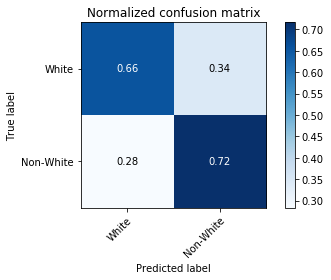

In [53]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['White', 'Non-White']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

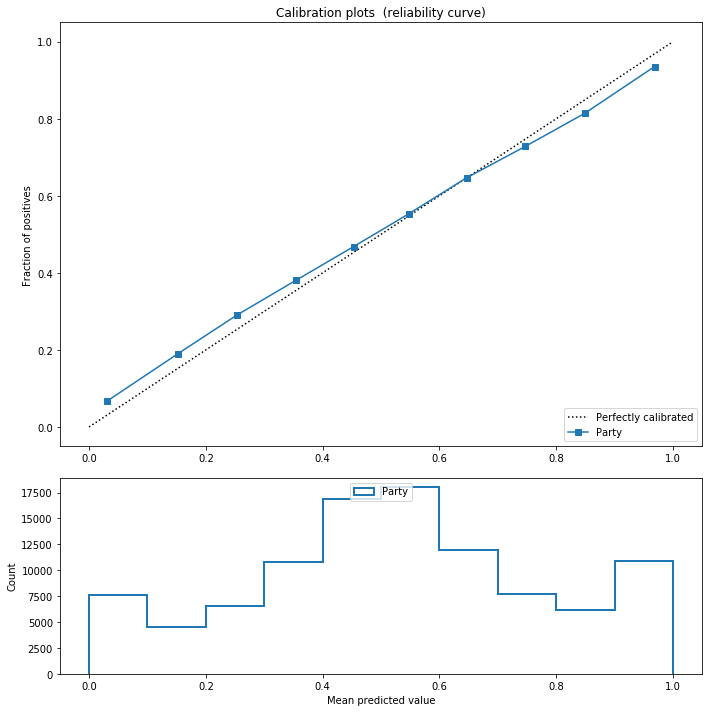

In [55]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Party')

In [56]:
del train, train_ids, train_pred_probs, train_target, train_vec

In [57]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(106095, 16)

In [58]:
descr_df.head()

,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
speech_id,,,,,,,,,,,,,,,,
1020203893,19920805,403,77,102108191.0,D,102,S,AZ,W,55.0,0.0,0.0,0.0,Mr. DECONCINI,"DECONCINI, DENNIS",exact
1030062300,19930721,799,139,103120531.0,D,103,S,MD,W,58.0,0.0,0.0,1.0,Ms. MIKULSKI,"MIKULSKI, BARBARA",exact
1100205980,20080927,1178,226,110116630.0,D,110,H,CA,W,67.0,0.0,0.0,0.0,Mr. BERMAN,"BERMAN, HOWARD",exact
990019658,19850404,2935,516,99114400.0,D,99,H,NY,B,50.0,1.0,1.0,0.0,Mr. OWENS,"OWENS, MAJOR",fuzzy
1130043981,20130801,1205,234,113120621.0,D,113,S,WA,W,64.0,0.0,0.0,1.0,Mrs. MURRAY,"MURRAY, PATTY",exact


In [59]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.091673       0.098836  57.724436  0.529214     0.6059    381.480277


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.63,0.52,0.99,0.48,0.95,1.08
0.6,0.77,0.81,1.00,0.96,0.97,0.76
1.0,1.50,1.56,1.01,1.45,1.06,1.16


In [60]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
service ambassadors 	 23564.8
the arvada 	 23318.7
ridge service 	 23318.7
arvada wheat 	 23318.7
overcome adversities 	 22857.9
attained with 	 21978.4
levels strive 	 21915.7
youth award 	 21360.7
ambassadors for 	 21359.6
adversities the 	 21066.7


bin,1,2,3,4
adversities the,0.0,0.0,2.0,40.0
ambassadors for,2.0,1.0,8.0,82.0
arvada wheat,0.0,0.0,1.0,81.0
attained with,1.0,0.0,1.0,41.0
levels strive,0.0,0.0,1.0,40.0
overcome adversities,0.0,0.0,1.0,41.0
ridge service,0.0,0.0,1.0,81.0
service ambassadors,0.0,0.0,1.0,82.0
the arvada,0.0,0.0,1.0,81.0
youth award,0.0,1.0,8.0,82.0


In [68]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 1.00):

date                       20080618
char_count                     4560
word_count                      812
speakerid               1.10119e+08
Party                             R
Congress                        110
Chamber                           H
State                            AZ
Ethnicity                         W
Age                              51
Age_lt_med                        1
NonWhite                          0
Female                            0
speaker       Mr. FRANKS of Arizona
Full Name             FRANKS, TRENT
match                         exact
Name: 1100175910, dtype: object

 Madam Speaker. I stand once again before this House with yet another Sunset Memorial. It is June 18. 2008 in the land of the free and the home of the brave. and before the sun sets today in America. almost 4.000 more defenseless unborn children were killed by abortion on demand. Thats just today. Madam Speaker. Thats more than the number of innocen